In [1]:
# TODO
# Collect at least 1000 gray image
# resize them 32X32 (1024)
# construct data matrix and covariance matrix using face image
# SVD ( PCA ) to the covariance matrix
# eigenvectors for largest singular values
# FINAL : Test for the recognition

In [2]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [3]:
file_M_path = "./res/faces/M/"
file_F_path = "./res/faces/F/"
file_M_list = os.listdir("./res/faces/M/")
file_F_list = os.listdir("./res/faces/F/")
sharpening_1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

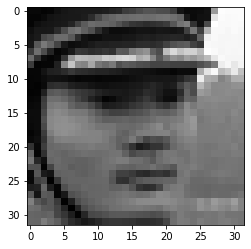

In [4]:
sample_img = cv2.imread(file_M_path + file_M_list[22], 0)
plt.imshow(sample_img, cmap='gray')
dst = cv2.resize(sample_img, dsize=(32, 32),interpolation=cv2.INTER_AREA)
plt.imshow(dst, cmap='gray')

In [5]:
# dst = cv2.bilateralFilter(dst, 9, 16, 16)
# plt.imshow(dst, cmap='gray')
# dst = cv2.filter2D(dst, -1, sharpening_1)
# plt.imshow(dst, cmap='gray')

In [6]:
data = np.array(dst)
l =data.flatten()
l.shape

(1024,)

In [7]:
man_pics = []
for file_M in file_M_list:
    man_pics.append(np.array(
        cv2.resize(cv2.imread(file_M_path + file_M, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA)
    ,dtype=np.float64).flatten())

sum_of_pics = sum(man_pics)

mean_of_pics = sum_of_pics / len(man_pics)

translation = man_pics - mean_of_pics

translation[1231].shape

(1024,)

In [8]:
U, s, V = np.linalg.svd(translation, full_matrices = True)

In [9]:
S = np.zeros(translation.shape)
for i in range(len(s)):
     S[i][i] = s[i]

In [10]:
appA = np.dot(U, np.dot(S, V))

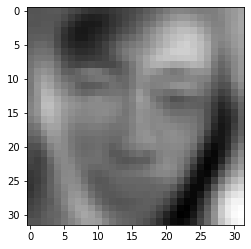

In [13]:
plt.imshow(V[11].reshape(32,32), cmap='gray')

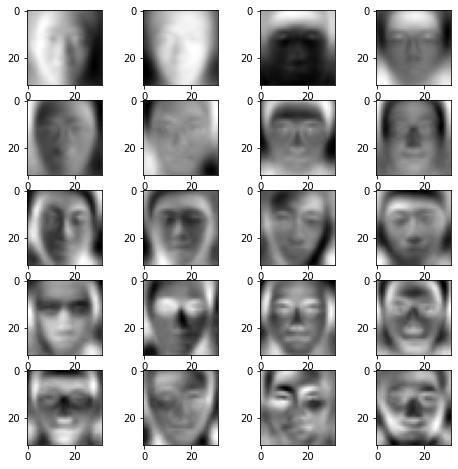

In [15]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = V[i].reshape(32,32)
#     img = l[np.random.randint(1024)].reshape(32,32)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [17]:
V[0]

array([-0.01540583, -0.01608087, -0.01698474, ..., -0.01889098,
       -0.01782428, -0.0169108 ])